Names: Mandus Aldag, Alexandros Mylonas

# Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scipy
import random

# Exercise 5.1

In [6]:
Jc = 0.5*np.log(1+np.sqrt(2))
abs_m = lambda J: (1-1/np.sinh(4*J)**4)**(1/8)*(J > Jc)
ϵ = lambda J: -J*1/np.tanh(2*J)*(1+2/np.pi*(2*np.tanh(2*J)**2-1)*scipy.ellipk(4/np.cosh(2*J)**2*np.tanh(2*J)**2))
for J in [4,1,0.5,1/3]:
    m = abs_m(J)
    eps = ϵ(J)
    print(f"J = {J}:|m| = {m}, ϵ = {eps}")

J = 4:|m| = 1.0, ϵ = -7.999999999999594
J = 1:|m| = 0.9999997746272086, ϵ = -1.9971602041122514
J = 0.5:|m| = 0.9992757519570612, ϵ = -0.8727822876562767
J = 0.3333333333333333:|m| = 0.0, ϵ = -0.27243653083414004


The function are correcly implemented.

/tmp/ipykernel_168124/3474193726.py:2: RuntimeWarning: invalid value encountered in power
  abs_m = lambda J: (1-1/np.sinh(4*J)**4)**(1/8)*(J > Jc)


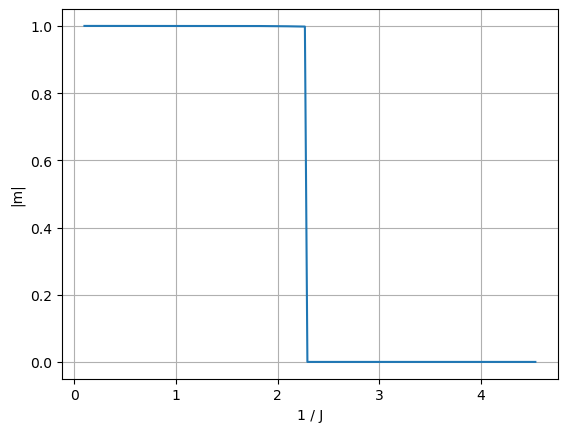

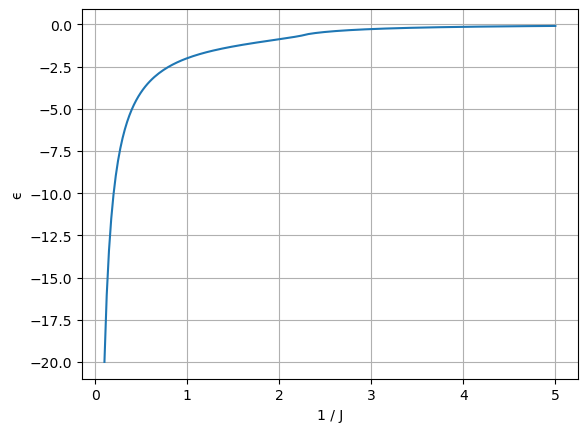

In [3]:
inverse_J = np.linspace(0.1,5,200)
ms = abs_m(1/inverse_J)
ϵs = ϵ(1/inverse_J)

plt.plot(inverse_J,ms)
plt.xlabel("1 / J")
plt.ylabel("|m|")
plt.grid()
plt.show()

plt.plot(inverse_J,ϵs)
plt.xlabel("1 / J")
plt.ylabel("ϵ")
plt.grid()
plt.show()
    

# Exercise 5.2

In [7]:
def metropolis_ising(spins, J, h, beta, L, steps):
    N = L * L  # Total number of spins
    m_history = []
    abs_m_history = []
    epsilon_history = []

    for _ in range(steps):
        for _ in range(N):  # Attempt to flip each spin once (on average)
            x = random.randint(0, N - 1)
            ΔH = delta_H(spins, J, h, x, L)
            if ΔH <= 0 or random.random() < np.exp(-beta * ΔH):
                spins[x] *= -1

        # Measure magnetization and energy
        m = np.sum(spins) / N
        abs_m = abs(m)
        epsilon = compute_energy(spins, J, h, L) / N

        # Store values
        m_history.append(m)
        abs_m_history.append(abs_m)
        epsilon_history.append(epsilon)

    return m_history, abs_m_history, epsilon_history


def delta_H(spins, J, h, x, L):
    i, j = x // L, x % L
    s = spins[x]
    right = i * L + (j + 1) % L
    left = i * L + (j - 1) % L
    up = ((i - 1) % L) * L + j
    down = ((i + 1) % L) * L + j
    neighbor_interactions = spins[right] + spins[left] + spins[up] + spins[down]
    return 2 * J * s * neighbor_interactions + 2 * h * s


def compute_energy(spins, J, h, L):
    N = L * L
    energy = 0
    for x in range(N):
        i, j = x // L, x % L
        right = i * L + (j + 1) % L
        down = ((i + 1) % L) * L + j
        energy -= J * spins[x] * (spins[right] + spins[down])
        energy -= h * spins[x]
    return energy

In [8]:
# Parameters
J = 0.5
h = 0.0
beta = 1.0  # Inverse temperature
steps = 10**5
Ns = [4, 8, 12]

# Generate data
histories = {}
for N in Ns:
    L = N
    spins = np.random.choice([-1, 1], size=(L * L))
    m_hist, abs_m_hist, epsilon_hist = metropolis_ising(spins, J, h, beta, L, steps)
    histories[N] = (m_hist, abs_m_hist, epsilon_hist)

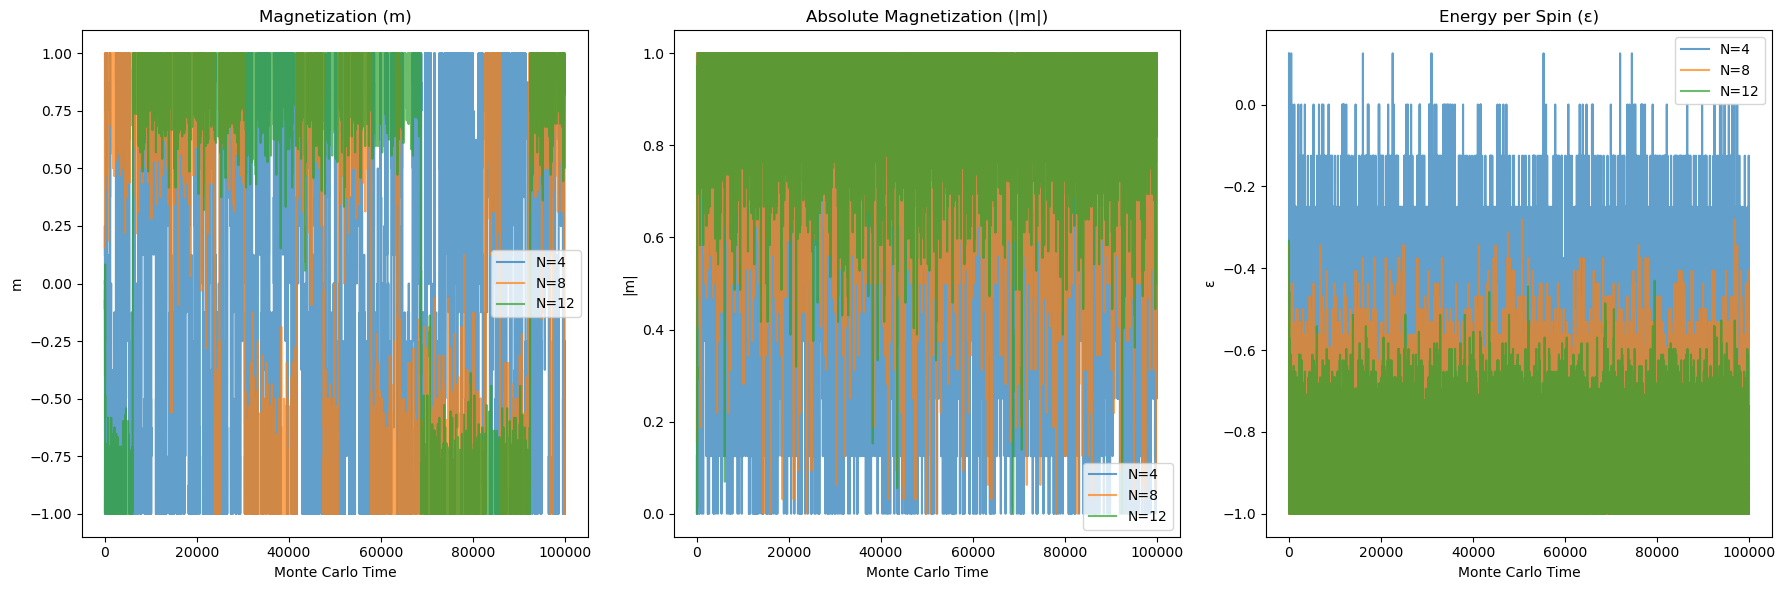

In [9]:
# Plotting
time = np.arange(steps)

plt.figure(figsize=(18, 6))

# Plot magnetization m
plt.subplot(1, 3, 1)
for N in Ns:
    plt.plot(time, histories[N][0], label=f'N={N}',alpha=0.7)
plt.title('Magnetization (m)')
plt.xlabel('Monte Carlo Time')
plt.ylabel('m')
plt.legend()

# Plot absolute magnetization |m|
plt.subplot(1, 3, 2)
for N in Ns:
    plt.plot(time, histories[N][1], label=f'N={N}',alpha=0.7)
plt.title('Absolute Magnetization (|m|)')
plt.xlabel('Monte Carlo Time')
plt.ylabel('|m|')
plt.legend()

# Plot energy per spin ε
plt.subplot(1, 3, 3)
for N in Ns:
    plt.plot(time, histories[N][2], label=f'N={N}',alpha=0.7)
plt.title('Energy per Spin (ε)')
plt.xlabel('Monte Carlo Time')
plt.ylabel('ε')
plt.legend()

plt.tight_layout()
plt.show()

At $J=0.5>Jc≈0.44$, the system is in the broken phase, meaning it exhibits spontaneous symmetry breaking in the thermodynamic limit $(N→∞)$. However, for finite $N$, the $\mathbb{Z}_{2}$ symmetry ensures that $\langle m \rangle=0$, as the system transitions between positive and negative magnetization states over time. This explains the Monte Carlo for $m$, where we observe oscillations around zero, reflecting the symmetry-preserving nature of finite systems. On the other hand, $|m|$ shows a consistently high value, indicative of strong spin alignment and the broken phase's ordered nature. The energy per spin  stabilizes quickly, further confirming the system's preference for lower-energy, ordered configurations. These observations align with the theoretical understanding that while $\langle m \rangle$=0 in finite systems, other metrics like $|m|$ and $\epsilon$ clearly reveal the underlying symmetry breaking.

# Exercise 5.3

In [14]:
def autocorrelation_time(data):
    n = len(data)
    mean = np.mean(data)
    variance = np.var(data)
    C = []

    # Compute autocorrelation function
    for lag in range(n):
        cov = np.mean((data[:n - lag] - mean) * (data[lag:] - mean))
        C.append(cov / variance)

    # Normalize C to get Γ
    Gamma = np.array(C) / C[0]

    # Find cutoff T where Γ crosses zero
    T = next((t for t, gamma in enumerate(Gamma) if gamma < 0), len(Gamma))
    print("T = ",T)

    # Compute integrated autocorrelation time
    tau = 0.5 + np.sum(Gamma[1:T])
    return tau


# Example Usage
auto_times = {}
for N in Ns:
    auto_times[N] = (autocorrelation_time(histories[N][0]),autocorrelation_time(histories[N][1]),autocorrelation_time(histories[N][2]))
    print(f"{N}:")
    print("Autocorrelation times:")
    print(f"τ_m = {auto_times[N][0]}")
    print(f"τ_|m| = {auto_times[N][1]}")
    print(f"τ_ε = {auto_times[N][2]}")


T =  627
T =  22
T =  19
4:
Autocorrelation times:
τ_m = 160.01739870919442
τ_|m| = 2.673597850954791
τ_ε = 2.4155973971918288
T =  15692
T =  44
T =  43
8:
Autocorrelation times:
τ_m = 4696.460421104069
τ_|m| = 6.451471324110643
τ_ε = 4.046512120575812
T =  18234
T =  133
T =  132
12:
Autocorrelation times:
τ_m = 7710.83337454476
τ_|m| = 12.641015145689291
τ_ε = 5.715321276325258


The results fit to the plots made in Exercise 2: The fluctuations are stronger for the absolute magnetisations and the energies. The autocorrelation times are therefore shorter than for the magnetisation m which has a long autocorrelation time. Also the smaller the lattice is, the bigger tend to be the fluctuations in the magnetisation. The autocorrelation time for the magnetisation is therefore way smaller for the N=4 case than for the N=8 or N=12 lattice.

The very slow autocorrelation time of
m is not important because, for
$h=0$, the $\mathbb{Z}_{2}$ symmetry ensures that
$\langle m \rangle$ in any finite system, regardless of the sampling dynamics. Since $m$ fluctuates symmetrically around zero, meaningful physical observables like $|m|$ or $\epsilon$, which directly reflect the system's ordering or energy, are unaffected by the slow autocorrelation of
$m$.

# Exercise 5.4

In [15]:
def bootstrap_analysis(data,auto_time,B):
    n = len(data)
    data = data[int(5*auto_time):] # account for thermalization
    data = data[:n:int(auto_time)] # decimating
    iid_length = len(data)

    exp_values = []
    for b in range(B):
            bootstrap_sample = []
            for i in range(iid_length):
                index = np.random.randint(0,iid_length)
                bootstrap_sample.append(data[index])
            exp_values.append(np.mean(bootstrap_sample))

    return exp_values

B = 1000
bootstrap = {}
for N in Ns:
     auto_time = max(auto_times[N][1],auto_times[N][2])
     bootstrap[N] = (bootstrap_analysis(histories[N][1],auto_time,B), bootstrap_analysis(histories[N][2],auto_time,B))
     print(f"N = {N}: |m|: {np.mean(bootstrap[N][0])} \u00B1 {np.std(bootstrap[N][0])}")
     print(f"N = {N}: ϵ: {np.mean(bootstrap[N][1])} \u00B1{np.std(bootstrap[N][0])}")
     




N = 4: |m|: 0.9195583570028404 ± 0.0006659129610029034
N = 4: ϵ: -0.8783761226347162 ±0.0006659129610029034
N = 8: |m|: 0.9126453982114993 ± 0.000795260539584648
N = 8: ϵ: -0.8738734264344016 ±0.000795260539584648
N = 12: |m|: 0.9112106512052934 ± 0.0007975801824058029
N = 12: ϵ: -0.8732148717333013 ±0.0007975801824058029


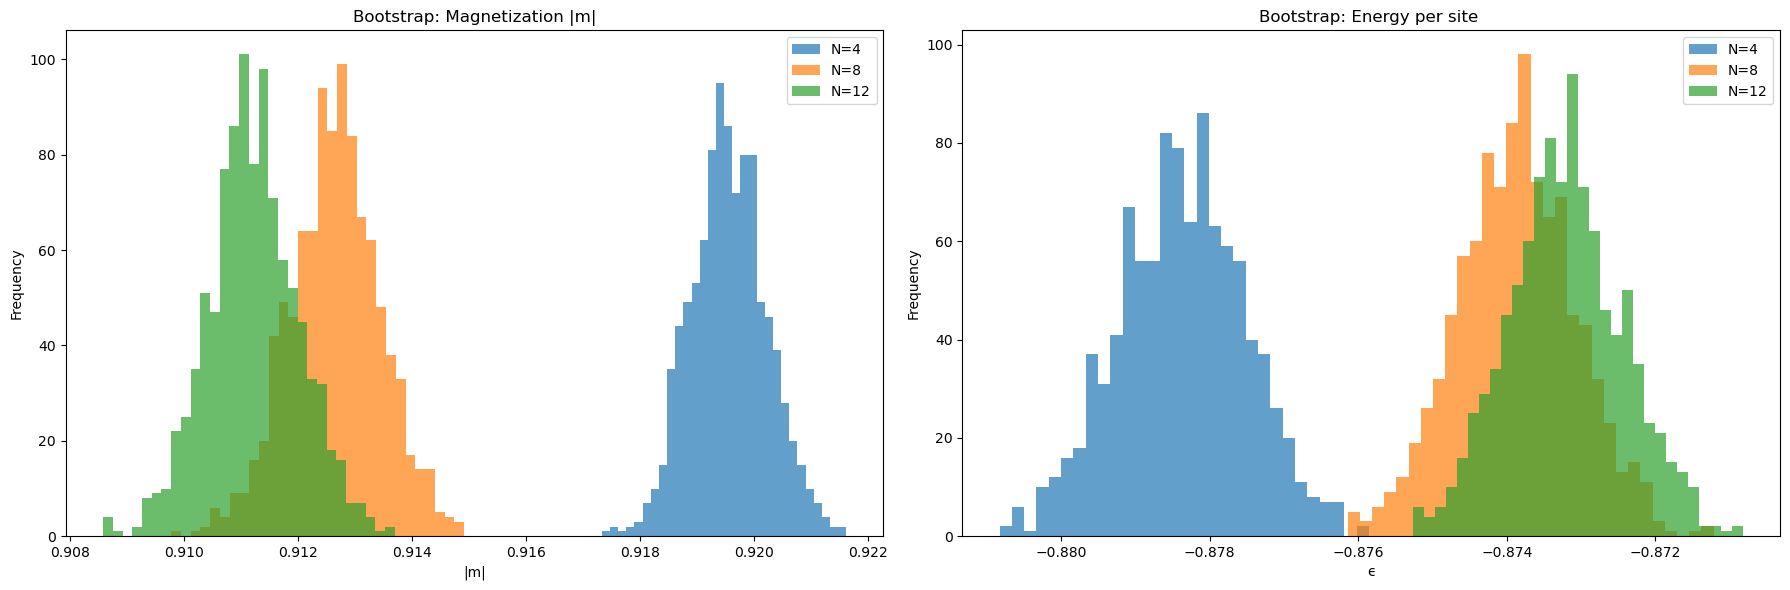

In [16]:
plt.figure(figsize=(18, 6))

# Plot magnetization |m|
plt.subplot(1, 2, 1)
for N in Ns:
    plt.hist(bootstrap[N][0], label=f'N={N}',alpha=0.7,bins=30)
plt.title('Bootstrap: Magnetization |m|')
plt.xlabel("|m|")
plt.ylabel('Frequency')
plt.legend()

# Plot absolute magnetization ϵ
plt.subplot(1, 2, 2)
for N in Ns:
    plt.hist(bootstrap[N][1], label=f'N={N}',alpha=0.7,bins=30)
plt.title('Bootstrap: Energy per site ')
plt.xlabel("ϵ")
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

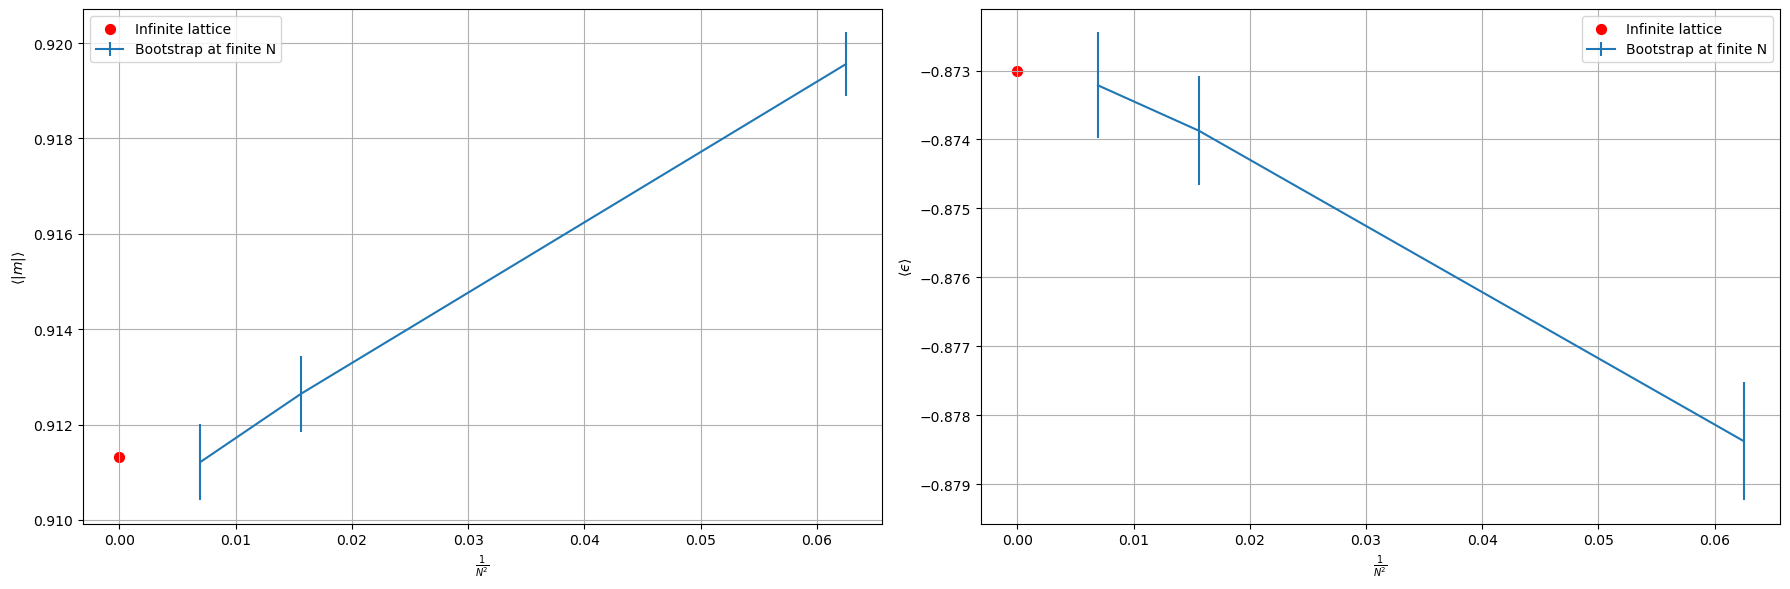

In [17]:
ym = []
ym_err = []
yϵ = []
yϵ_err= []
for N in Ns:
    ym.append(np.mean(bootstrap[N][0]))
    ym_err.append(np.std(bootstrap[N][0]))
    yϵ.append(np.mean(bootstrap[N][1]))
    yϵ_err.append(np.std(bootstrap[N][1]))

x = 1/np.array(Ns)**2
m_inf = 0.9113194
ϵ_inf = -0.873
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.errorbar(x,ym,ym_err,label="Bootstrap at finite N")
plt.scatter([0],[m_inf],color="red",label="Infinite lattice",s=50)
plt.xlabel(r"$\frac{1}{N^2}$")
plt.ylabel(r"$\langle |m| \rangle $")
plt.grid()
plt.legend(loc=2)

plt.subplot(1, 2, 2)
plt.errorbar(x,yϵ,yϵ_err,label="Bootstrap at finite N")
plt.scatter([0],[ϵ_inf],color="red",label="Infinite lattice",s=50)
plt.xlabel(r"$\frac{1}{N^2}$")
plt.ylabel(r"$\langle ϵ \rangle $")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

With growing lattice sizes (here on the x-axis towards 0) the expectation values for the absolute magnetisations and the energy per site go towards the analytical values for infinite systems. It can be expected that with more simulations in bigger systems this behaviour continues. The standard deviation does not seem to change with system size for |m|; from the right plot one might think that the standard deviation grows with smaller systems for |ϵ|. More samples would clarify this question.